In [5]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

In [ ]:
!unzip /content/gdrive/MyDrive/GdriveXbot/archive.zip -d /content/gdrive/MyDrive/temp

# Imports

In [1]:
# for pre-processing
import os
import shutil
import numpy as np
import pandas as pd
import cv2
import random
from matplotlib.image import imread
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

# for neural networks
from keras.applications import MobileNetV2, Xception
import tensorflow as tf
from sklearn.model_selection import cross_validate, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPool2D,Dropout

# for feaure selection
from scipy.stats import pearsonr
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

plt.rcParams['figure.dpi'] = 150

# Load and pre-processing images

In [ ]:
for x in os.listdir("/content/gdrive/MyDrive/temp/chest_xray/test"):
  print(x+": "+str(len(os.listdir(os.path.join("/content/gdrive/MyDrive/temp/chest_xray/test",x)))))

NORMAL: 234
PNEUMONIA: 390


In [ ]:
for x in os.listdir("/content/gdrive/MyDrive/temp/chest_xray/train"):
  print(x+": "+str(len(os.listdir(os.path.join("/content/gdrive/MyDrive/temp/chest_xray/train",x)))))

NORMAL: 1341
PNEUMONIA: 3875


In [ ]:
for x in os.listdir("/content/gdrive/MyDrive/temp/chest_xray/val"):
  print(x+": "+str(len(os.listdir(os.path.join("/content/gdrive/MyDrive/temp/chest_xray/val",x)))))

NORMAL: 8
PNEUMONIA: 8


In [ ]:
metadata=pd.read_csv("/content/covid-chestxray-dataset/metadata.csv")

In [ ]:
len(os.listdir("/content/covid-chestxray-dataset/images"))

930

In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   patientid               950 non-null    object 
 1   offset                  697 non-null    float64
 2   sex                     870 non-null    object 
 3   age                     713 non-null    float64
 4   finding                 950 non-null    object 
 5   RT_PCR_positive         593 non-null    object 
 6   survival                361 non-null    object 
 7   intubated               248 non-null    object 
 8   intubation_present      250 non-null    object 
 9   went_icu                397 non-null    object 
 10  in_icu                  335 non-null    object 
 11  needed_supplemental_O2  90 non-null     object 
 12  extubated               37 non-null     object 
 13  temperature             78 non-null     float64
 14  pO2_saturation          119 non-null    fl

In [ ]:
metadata["finding"].unique()

array(['Pneumonia/Viral/COVID-19', 'Pneumonia', 'Pneumonia/Viral/SARS',
       'Pneumonia/Fungal/Pneumocystis',
       'Pneumonia/Bacterial/Streptococcus', 'No Finding',
       'Pneumonia/Bacterial/Chlamydophila', 'Pneumonia/Bacterial/E.Coli',
       'Pneumonia/Bacterial/Klebsiella', 'Pneumonia/Bacterial/Legionella',
       'Unknown', 'Pneumonia/Lipoid', 'Pneumonia/Viral/Varicella',
       'Pneumonia/Bacterial', 'Pneumonia/Bacterial/Mycoplasma',
       'Pneumonia/Viral/Influenza', 'todo', 'Tuberculosis',
       'Pneumonia/Viral/Influenza/H1N1', 'Pneumonia/Fungal/Aspergillosis',
       'Pneumonia/Viral/Herpes ', 'Pneumonia/Aspiration',
       'Pneumonia/Bacterial/Nocardia', 'Pneumonia/Viral/MERS-CoV',
       'Pneumonia/Bacterial/Staphylococcus/MRSA'], dtype=object)

In [ ]:
metadata=metadata.drop(metadata[metadata["finding"].str.contains("No Finding")].index)
metadata=metadata.drop(metadata[metadata["finding"].str.contains("Unknown")].index)
metadata=metadata.drop(metadata[metadata["finding"].str.contains("todo")].index)

In [ ]:
metadata=metadata.reset_index()

In [ ]:
metadata.loc[8]["finding"]

'Pneumonia/Viral/COVID-19'

**Making new dataset of mine**

In [ ]:
for i in range(len(metadata)):
  try:
    if(metadata.loc[i]["finding"]=="Pneumonia/Viral/COVID-19"):
      shutil.copyfile(os.path.join("/content/covid-chestxray-dataset/images",metadata.loc[i]["filename"]),os.path.join("/content/data/covid",metadata.loc[i]["filename"]))
    else:
      shutil.copyfile(os.path.join("/content/covid-chestxray-dataset/images",metadata.loc[i]["filename"]),os.path.join("/content/data/non-covid",metadata.loc[i]["filename"]))
  except:
    print(metadata.loc[i]["filename"])

radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm.nii.gz
radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii.gz
coronacases_org_001.nii.gz
coronacases_org_002.nii.gz
coronacases_org_003.nii.gz
coronacases_org_004.nii.gz
coronacases_org_005.nii.gz
coronacases_org_006.nii.gz
coronacases_org_007.nii.gz
coronacases_org_008.nii.gz
coronacases_org_009.nii.gz
coronacases_org_010.nii.gz
radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm.nii.gz
radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.nii.gz
radiopaedia_org_covid-19-pneumonia-29_86491_1-dcm.nii.gz
radiopaedia_org_covid-19-pneumonia-23_86359_0-dcm.nii.gz
radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii.gz
radiopaedia_org_covid-19-pneumonia-10_85902_3-dcm.nii.gz
radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm.nii.gz
radiopaedia_org_covid-19-pneumonia-27_86410_0-dcm.nii.gz
radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm.nii.gz


In [ ]:
print(len(os.listdir("/content/data/covid")))
print(len(os.listdir("/content/data/non-covid")))

563
260


In [ ]:
563-260

303

In [ ]:
files=os.listdir("/content/gdrive/MyDrive/temp/chest_xray/train/PNEUMONIA")

In [ ]:
for x in range(303):
  number=random.randint(0,3875)
  shutil.copyfile(os.path.join("/content/gdrive/MyDrive/temp/chest_xray/train/PNEUMONIA",files[number]),os.path.join("/content/data/non-covid",files[number]))

In [ ]:
print(len(os.listdir("/content/data/covid")))
print(len(os.listdir("/content/data/non-covid")))

563
563


In [ ]:
!unzip /content/gdrive/MyDrive/data.zip -d /content/data

In [ ]:
!zip -r /content/data.zip  /content/gdrive/MyDrive/data

In [ ]:
data_path="/content/gdrive/MyDrive/data"

**Image analysis**

In [ ]:
imagesInfo=[[],[],[]]

for subdir in os.listdir(data_path):
  for image in os.listdir(os.path.join(data_path, subdir)):
    img=Image.open(os.path.join(data_path, subdir, image))
    imagesInfo[0].append(img.size[0])
    imagesInfo[1].append(img.size[1])
    imagesInfo[2].append(img.mode)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(702.0238095238095, 0.5, 'number of vertical pixels')

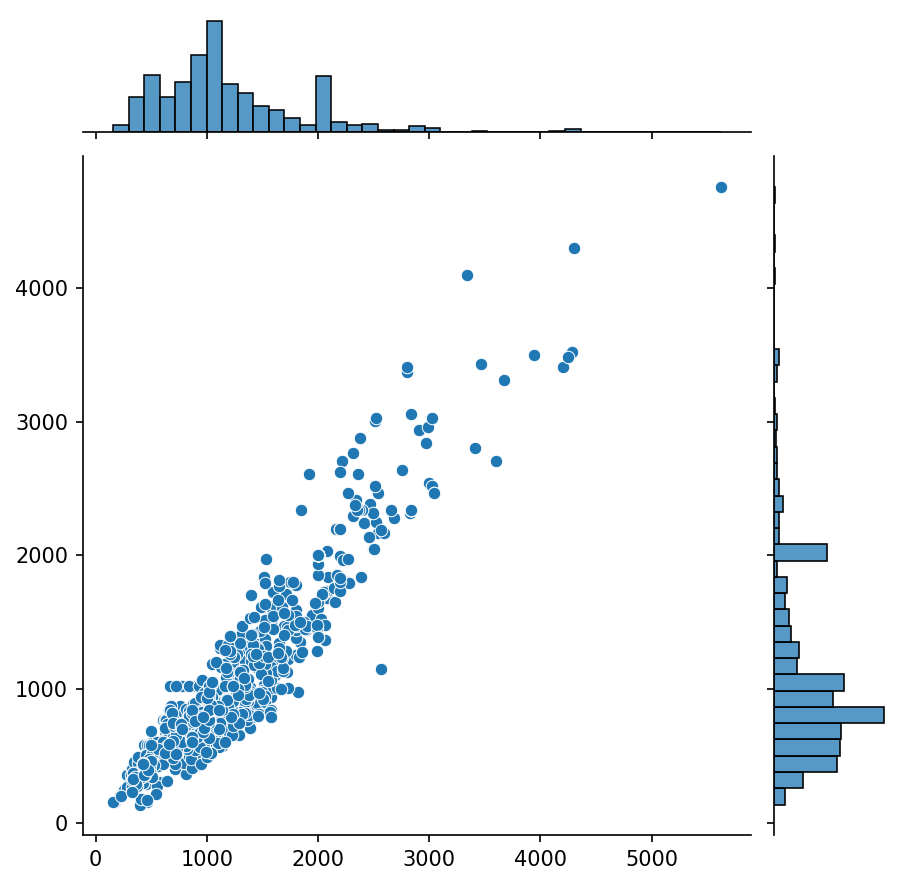

In [ ]:
sns.jointplot(imagesInfo[0],imagesInfo[1])
plt.xlabel("number of horizental pixels")
plt.ylabel("number of vertical pixels")

In [ ]:
print(np.average(imagesInfo[0]))
print(np.average(imagesInfo[1]))

1206.448490230906
1049.0657193605684


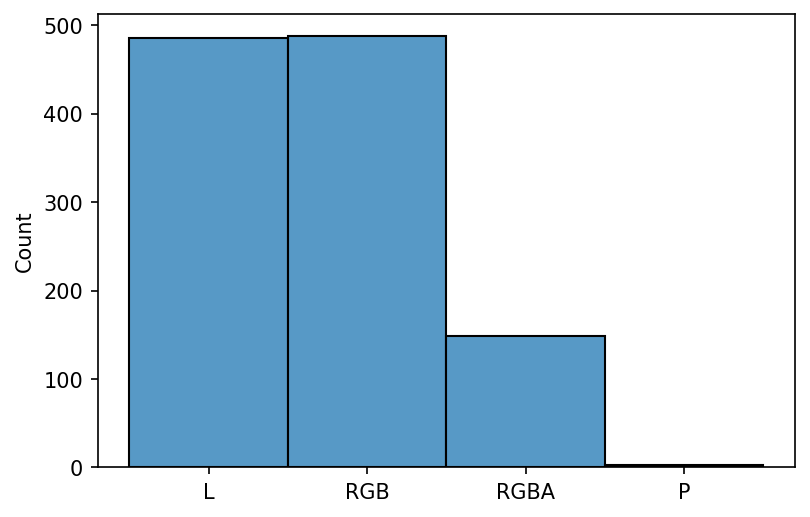

In [ ]:
sns.histplot(imagesInfo[2])

**transforming to black and white**

In [ ]:
images=[]
for subdir in os.listdir(data_path):
  for image in os.listdir(os.path.join(data_path, subdir)):
    images.append([np.asarray(Image.open(os.path.join(data_path, subdir,image)).convert("L")), subdir])

In [ ]:
counter=0

for x in images:
  temp=Image.fromarray(x[0])

  if x[1]=="covid":
    temp.save("/content/gdrive/MyDrive/content/data/covid/"+str(counter)+".jpeg")
  else:
    temp.save("/content/gdrive/MyDrive/content/data/non-covid/"+str(counter)+".jpeg")
  
  counter+=1

In [ ]:
# second step
images=[]
for subdir in os.listdir(data_path):
  counter=0
  for image in os.listdir(os.path.join(data_path, subdir)):
    images.append([Image.open(os.path.join(data_path, subdir,image)),subdir])
    if counter==399:
      break
    counter+=1

# Feature Extraction

In [ ]:
def ImageNet(image):
  base_model=MobileNetV2(
  include_top=False,
  input_shape=(240,240,3),
  weights="imagenet")
  
  base_model.trainable=False

  image=cv2.resize(np.asarray(image),(240, 240), cv2.INTER_LINEAR)
  image= np.repeat(image[..., np.newaxis], 3, -1)
  image=np.expand_dims(image,axis=0)

  prediction_layer= MaxPool2D(pool_size=(8,8))
  x = base_model(image, training=False)
  outputs = prediction_layer(x)

  return outputs

In [ ]:
mobilenet_results=[]
for i in images:
  mobilenet_results.append([ImageNet(i[0]), 1 if i[1]=="covid" else 0])

In [ ]:
mobilenet_results[0][0].shape    

TensorShape([1, 1, 1, 1280])

In [ ]:
mobilenet=[]
for x in mobilenet_results:
  mobilenet.append([np.reshape(x[0],[1280]),x[1]])

In [ ]:
mobilenet[0]

[array([3.855716  , 6.        , 0.        , ..., 0.44303927, 4.786076  ,
        5.54933   ], dtype=float32), 1]

In [ ]:
np.save("/content/gdrive/MyDrive/mobilenet", mobilenet)

/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
def xception(image):
  base_model=Xception(
  include_top=False,
  input_shape=(299,299,3),
  weights="imagenet")
  
  base_model.trainable=False

  image=cv2.resize(np.asarray(image),(299, 299), cv2.INTER_LINEAR)
  image= np.repeat(image[..., np.newaxis], 3, -1)
  image=np.expand_dims(image,axis=0)

  prediction_layer1= MaxPool2D(pool_size=(10,10))
  x = base_model(image, training=False)
  outputs = prediction_layer1(x)

  return outputs

In [ ]:
xception_results=[]
counter=0
for i in images:
  counter+=1
  print(counter)
  xception_results.append([xception(i[0]), 1 if i[1]=="covid" else 0])

In [ ]:
xception_results[0][0].shape

TensorShape([1, 1, 1, 2048])

In [ ]:
xception=[]
for x in xception_results:
  xception.append([np.reshape(x[0],[2048]),x[1]])

In [ ]:
np.save("/content/gdrive/MyDrive/xception", xception)

In [ ]:
mobilenet = np.load("/content/gdrive/MyDrive/mobilenet.txt.npy",allow_pickle=True)
xception = np.load("/content/gdrive/MyDrive/xception.txt.npy",allow_pickle=True)

In [ ]:
xception[0][0].shape

(2048,)

In [ ]:
print(np.asarray(xception).shape)
print(np.asarray(mobilenet).shape)

(800, 2)
(800, 2)


<ipython-input-49-35d1336ceb4a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.asarray(xception).shape)
<ipython-input-49-35d1336ceb4a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.asarray(mobilenet).shape)


In [ ]:
feature_extracted_matrix=[]

for i in range(len(xception)):
  feature_extracted_matrix.append(np.concatenate((mobilenet[i][0],xception[i][0],xception[i][1]), axis=None))

In [ ]:
np.save("/content/gdrive/MyDrive/main", feature_extracted_matrix)

In [6]:
feature_extracted_matrix=np.load("/content/gdrive/MyDrive/main.npy")

In [8]:
feature_extracted_matrix=np.array(feature_extracted_matrix)

In [ ]:
feature_extracted_matrix.shape

(800, 3329)

# Feature selection

In [9]:
correlations=[]

for x in range(3329):
  correlations.append(pearsonr(feature_extracted_matrix[:,x],feature_extracted_matrix[:,-1]))

correlations=np.array(correlations)

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [ ]:
correlations[0]

array([-1.38489921e-01,  8.49764165e-05])

*Correlation and pearson-r plot*

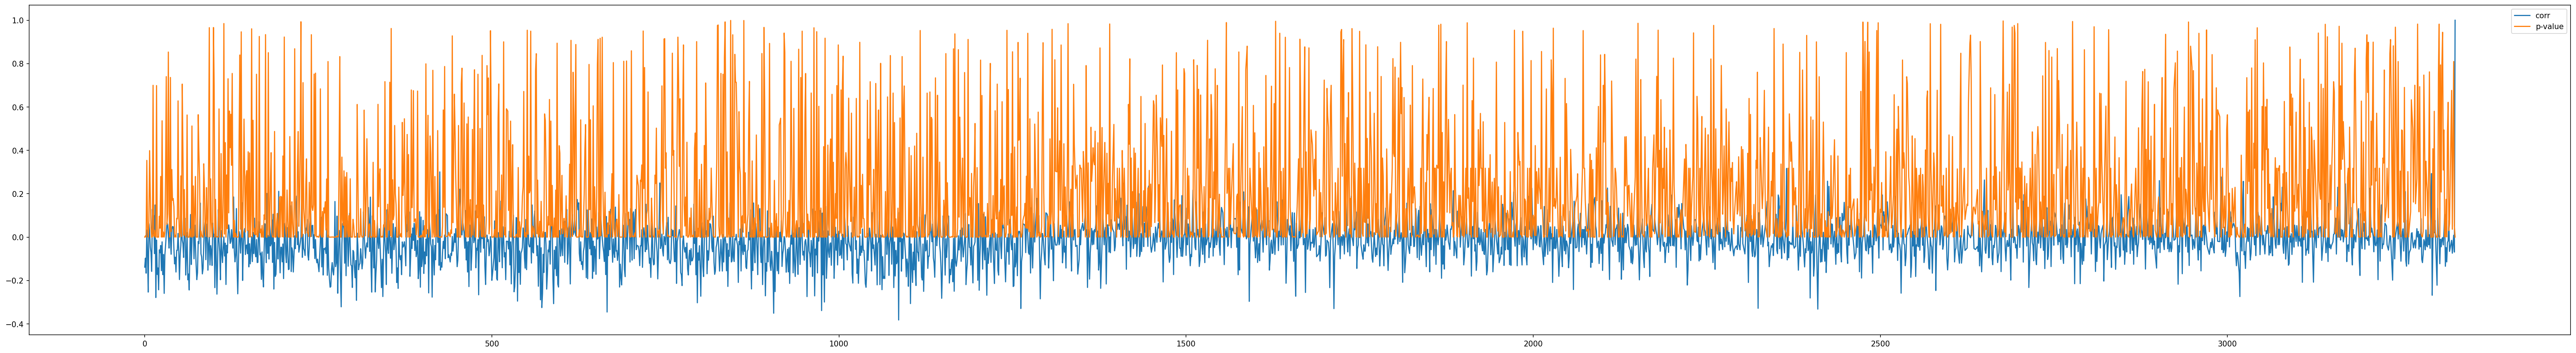

In [ ]:
plt.figure(figsize=(60,8))
sns.lineplot(x=range(3329),y=correlations[:,0])
sns.lineplot(x=range(3329),y=correlations[:,1])
plt.legend(["corr","p-value"])
plt.savefig("corr-p.png")

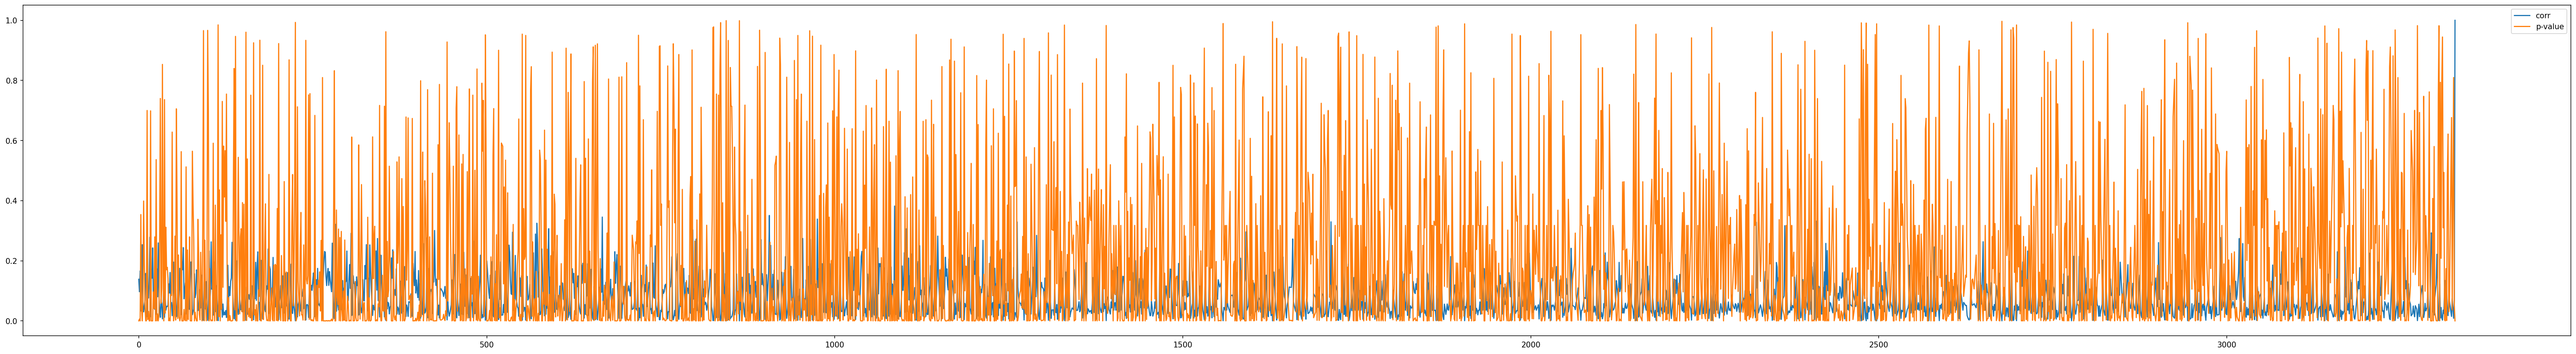

In [ ]:
plt.figure(figsize=(60,8))
sns.lineplot(x=range(3329),y=abs(correlations[:,0]))
sns.lineplot(x=range(3329),y=correlations[:,1])
plt.legend(["corr","p-value"])
plt.savefig("corr-p2.png")

In [ ]:
highCorr_cols=[]

for x in range(len(correlations)):
  if abs(correlations[x][0])>=.8:
    highCorr_cols.append(x)

In [ ]:
correlations.shape

(3329, 2)

In [ ]:
highCorr_cols

[3328]

In [ ]:
feature_extracted_matrix.shape

(800, 3329)

In [ ]:
pip install mlxtend --upgrade

In [10]:
x=feature_extracted_matrix[:,:-1]
y=feature_extracted_matrix[:,-1]

In [ ]:
sfs1 = sfs(KNeighborsClassifier(),
           k_features=15,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5,
           n_jobs=-1)

# Perform SFFS
sfs1 = sfs1.fit(x,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 1262 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1992 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2882 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3325 out of 3328 | elapsed:  2.2min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3328 out of 3328 | elapsed:  2.2min finished

[2022-12-14 18:46:15] Features: 1/15 -- score: 0.66125[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 612 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1424 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 2556 tasks      | elapsed:  1.3min
[Parallel(n_

In [ ]:
feat_cols=list(sfs1)

[408,
 647,
 728,
 1600,
 1808,
 2002,
 2181,
 2421,
 2496,
 2646,
 2753,
 2762,
 2771,
 3224,
 3295]

In [11]:
final_features=feature_extracted_matrix[:,feat_cols]

# Classification

In [15]:
svc=SVC()
scores = cross_validate(svc, final_features, y, cv=10, scoring=["accuracy","f1","recall","precision","roc_auc"])

In [16]:
scores

{'fit_time': array([0.02328515, 0.01835513, 0.01793289, 0.01834702, 0.01807976,
        0.01816535, 0.0179503 , 0.01968312, 0.01853871, 0.01829672]),
 'score_time': array([0.00866771, 0.00844431, 0.00840116, 0.00825787, 0.01038885,
        0.00833893, 0.00928378, 0.00820351, 0.00857425, 0.01085997]),
 'test_accuracy': array([0.7   , 0.65  , 0.8125, 0.6375, 0.625 , 0.675 , 0.65  , 0.675 ,
        0.8125, 0.7125]),
 'test_f1': array([0.76      , 0.70212766, 0.82352941, 0.70707071, 0.67391304,
        0.72340426, 0.72      , 0.7173913 , 0.84210526, 0.76767677]),
 'test_recall': array([0.95 , 0.825, 0.875, 0.875, 0.775, 0.85 , 0.9  , 0.825, 1.   ,
        0.95 ]),
 'test_precision': array([0.63333333, 0.61111111, 0.77777778, 0.59322034, 0.59615385,
        0.62962963, 0.6       , 0.63461538, 0.72727273, 0.6440678 ]),
 'test_roc_auc': array([0.7390625, 0.641875 , 0.82125  , 0.7971875, 0.6615625, 0.72     ,
        0.7475   , 0.7165625, 0.86875  , 0.8009375])}

In [17]:
print("accuracy: "+ str(max(scores["test_accuracy"])))
print("test_f1: "+ str(max(scores["test_f1"])))
print("test_recall: "+ str(max(scores["test_recall"])))
print("test_precision: "+ str(max(scores["test_precision"])))

accuracy: 0.8125
test_f1: 0.8421052631578948
test_recall: 1.0
test_precision: 0.7777777777777778


In [ ]:
print("accuracy: "+ str(min(scores["test_accuracy"])))
print("test_f1: "+ str(min(scores["test_f1"])))
print("test_recall: "+ str(min(scores["test_recall"])))
print("test_precision: "+ str(min(scores["test_precision"])))

accuracy: 0.625
test_f1: 0.6739130434782609
test_recall: 0.775
test_precision: 0.5932203389830508


In [27]:
weights={"C":[5,10,15,20,25,30,35],"gamma":[.1,.01,.001,.0001,.00001]}
svc_gscv=GridSearchCV(svc,weights)
svc_gscv.fit(final_features,y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [5, 10, 15, 20, 25, 30, 35],
                         'gamma': [0.1, 0.01, 0.001, 0.0001, 1e-05]})

In [28]:
print(f"{svc_gscv.best_params_=} is the best parameter")
print(f"{svc_gscv.best_score_=} is the best score")

svc_gscv.best_params_={'C': 5, 'gamma': 0.1} is the best parameter
svc_gscv.best_score_=0.7200000000000001 is the best score


In [22]:
rfc=RandomForestClassifier()
scores = cross_validate(rfc, final_features, y, cv=10, scoring=["accuracy","f1","recall","precision"])

In [23]:
print("accuracy: "+ str(max(scores["test_accuracy"])))
print("test_f1: "+ str(max(scores["test_f1"])))
print("test_recall: "+ str(max(scores["test_recall"])))
print("test_precision: "+ str(max(scores["test_precision"])))

accuracy: 0.8
test_f1: 0.8000000000000002
test_recall: 0.875
test_precision: 0.8


In [50]:
clf = BernoulliNB()

In [51]:
scores = cross_validate(clf, final_features, y, cv=10, scoring=["accuracy","f1","recall","precision"])

In [52]:
print("accuracy: "+ str(max(scores["test_accuracy"])))
print("test_f1: "+ str(max(scores["test_f1"])))
print("test_recall: "+ str(max(scores["test_recall"])))
print("test_precision: "+ str(max(scores["test_precision"])))

accuracy: 0.8625
test_f1: 0.8705882352941177
test_recall: 0.925
test_precision: 0.8333333333333334


In [58]:
weights={"alpha":[.1,.2,.3,.4,.5,.6,.7,.8,.9,1]}
clf_gscv=GridSearchCV(clf,weights)
clf_gscv.fit(final_features,y)

GridSearchCV(estimator=BernoulliNB(),
             param_grid={'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1]})

In [59]:
print(f"{clf_gscv.best_params_=} is the best parameter")
print(f"{clf_gscv.best_score_=} is the best score")

clf_gscv.best_params_={'alpha': 0.1} is the best parameter
clf_gscv.best_score_=0.73625 is the best score
